<h1>Clustering</h1>

Clustering is an <b>unsupervised</b> group of algorithims which cluster 'similar' data points together. In this example, we are going to cluster together groups of pokemon based on their <b>'Battle Archetype'</b>. Clusters could represent different groups or demographics we are interested in within a dataset.

<b>What is a Battle Archetype?</b><br>

Short answer: a battle archetype is a category which best describes how a pokemon fits into a team and what it might be used for.<br>

Long Answer: In competitive pokemon battling, a pokemon is usually selected because it performs very well at a given role in a team. For example, the pokemon 'Gengar' is considered to be a special sweeper. This is because he has a high speed and high sp. atk stat, and his other stats are probably not that great. The pokemon 'Shuckle' is considered a stalling or wall pokemon, because it has low attack stats and speed but very high defensive stats.

The following clustering methods will be covered using standard library functions, but there are others:<br>
k means<br>
Hierarchical<br>
Fuzzy C Means (FCM)<br>
Evolving Clustering <br>
**remove before publish (just do some reading if these aren't 'real' topics)**<br>
Clustering Data Streams<br>

In [ ]:
#possibly need to install this library as it is not standard to kaggle kernels
#make sure 'internet' is turned on in the settings
!pip install scikit-fuzzy

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE #T distributed stochastic neighbour embedding

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
import skfuzzy as fuzz

df_full = pd.read_csv("../input/Pokemon.csv")

print("setup and imports complete")

setup and imports complete


In [ ]:
df_full.head()

<h3>Data preperation and clean up</h3>

In [ ]:
#build up a type list and include a type for none
type_list = df_full['Type 1'].unique().tolist()
type_list.append('none')
#replace NaN for 'Type 2' with 'none' so it will work with the LabelEncoder
df_full['Type 2'].fillna('none',inplace=True)

#use the label encoder to convert the type names, e.g 'Grass' into integers
le = LabelEncoder()
le.fit(type_list)
LabelEncoder()

df_full['Type 1'] = le.transform(df_full['Type 1'])
df_full['Type 2']  = le.transform(df_full['Type 2'])

features = ['#','Type 1','Total','HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Generation','Legendary']

In [ ]:
#in Python, True is the integer 1 and False is the number 0. No further changes required.
df_full[features].sample(frac=1).head()

<h3>K means clustering</h3>
The number of clusters must be decided by the person running the algorithm. A way to help find optimal number of clusters is an elbow plot. Another way is to start with 2 Clusters and add more clusters, checking the variance each time and seeing if they're equal.

Here's how it works in steps:<br><br>
<b>Step 1</b>: Choose the number of clusters to make. For instance k = 4 <br><br>
<b>Step 2</b>: then select 4 data points at random <br><br>
<b>Step 3</b>: measure the distance between the 1st data point and the initial clusters, and assign that point to the nearest cluster <br><br>
<b>Step 4</b>: start assiging the unassigned points. Measure the distance to the initial mean cluster points and assign the point to the nearest cluster. <br><br>
<b>Step 5</b>: Calculate the mean of each cluster, and then use the mean value as the point to measure the data points to, recluster the data. If the clusters change from one clustering to the next, this process continues. If the clusters do not change, the clustering will stop.<br><br>
<b>Step 6</b>: Once we have the 'final' cluster, we sum up the variation in the clustering and then repeat the process. K-means assumes that the variance in each cluster group is the same. So it is trying to make the clusters approximately the same size, with the same amount of variation in each group. The process finishes when it reaches this point.<br><br>
The example below will theoretically show us which pokemon are good special sweepers (and which are likely good physical attack sweepers).<br> <br>


In [ ]:
def GenKmeans(X, nclust=2):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = GenKmeans(df_full[['Sp. Atk','Speed']], 4)
kmeans = pd.DataFrame(clust_labels)
df_full.insert((df_full.shape[1]),'kmeans',kmeans)
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(df_full['Sp. Atk'],df_full['Speed'],c=kmeans[0],s=50)

ax.set_title('K-Means Clustering (sp. Atk sweepers)')
ax.set_xlabel('Sp. Attack')
ax.set_ylabel('Speed')

plt.colorbar(scatter)

In [ ]:
#looking at the results of these two queries
#we can see the k-means = 4 has done a good job of clustering
#Special attack sweepers
df_full[(df_full['Speed'] > 120) & (df_full['Sp. Atk'] > 120)]

#probably physical attack sweepers
df_full[(df_full['Speed'] > 120) & (df_full['Sp. Atk'] < 80)]

<h4>Identifying the optimal number of clusters with elbow plots</h4>
As more clusters are added, the average distance from data points to their mean centroids reduces.<br>
We can use this to our advantage to find out the number of clusters where we can see adding an extra cluster does not reduce the average distance much.<br><br> The graph is called an elbow graph because of the obtuse angle the line makes as the sum of squares reduces. The 'optimal' number of clusters appears when the sum of squares is reducing at a very low rate. It is highlighted with a red circle in this example. <br><br>
<b>To Add Later: </b>More frequently, I have seen these graphs which look at 'Percentage of variance explained'. I will look into adding this shortly, although it does not seem straightforward to get the variance for each number of clusters in the iteration in scikit's version of kmeans. If you are reading this and know how it is done, please fork the kernel and help me out!

In [ ]:
centroid_list = []
X = df_full[['Sp. Atk','Speed']]

for i in range(1,10):
    model = KMeans(n_clusters=i)
    model.fit(X)
    centroid_list.append(model.cluster_centers_)

centroid_dists = [cdist(df_full[['Sp. Atk','Speed']].values, cent, 'euclidean') for cent in centroid_list]
short_dist = [np.min(x,axis=1) for x in centroid_dists]
avgInSqSum = [sum(x)/X.shape[0] for x in short_dist]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,10), avgInSqSum, 'b*-')

ax.plot([4], avgInSqSum[3], marker='o',
        markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')

plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow Plot KMeans')
plt.show()

In [ ]:
#A look at 2 to 5 clusters, which is visually illustrates what the elbow plot was showing
#(that 5 clusters is probably one too many)
for i in range(2,6):
    X = df_full[['Sp. Atk','Speed']]
    model = KMeans(n_clusters=i)
    model.fit(X)
    clust_labels = model.predict(X)
    kmeans = pd.DataFrame(clust_labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df_full['Sp. Atk'],df_full['Speed'],c=kmeans[0],s=50)
    ax.set_title('K-Means Clustering (sp. Atk sweepers)')
    ax.set_xlabel('Sp. Attack')
    ax.set_ylabel('Speed')
    plt.colorbar(scatter)
plt.show()

<h3>Hierarchical Clustering</h3>

Hierarchical clustering methods are usually one of two general approaches:<br>
<b>Agglomerative</b>: These are bottom up approaches, where you start out with individual data points and build up the clusters until reaching the top cluster, which is all of the data in one cluster.<br>
<b>Divisive</b>: These are top down approaches, starting with the enitre data set and dividing it down.

This kernel focuses on agglomerative methods since there does not seem to be any divisive methods in scikit learn.<br><br>
Clusters are formed based on how 'similar' one data point is to another. An initial cluster will be formed by comparing the first data point with a point which is closest (distance metric is based on the 'linkage' parameters in this example, full explanation of those is in the sci kit documentation).<br> Then that cluster will be used in comparisions when deciding where to place other data points. If the other data points are similar to the existing cluster, it will be added to that cluster. Otherwise, it will create a new cluster. This process repeats until we reach the top of the tree (dendrogram), where there is only 1 big cluster.

In [ ]:
X = df_full[['Sp. Atk','Speed']]
hier_eucl = ("Euclidean hierarchical",
             AgglomerativeClustering(n_clusters=4,
                                     affinity='euclidean',
                                     linkage='ward'))

#linkage type 'ward' only works with euclidean distance
#the options for linkage strategies are: single, average and complete
#complete seems to work the best in this situation
hier_manh = ("Manhattan Complete Hierarchical",
             AgglomerativeClustering(n_clusters=4,
                                     affinity='manhattan',
                                     linkage='complete'))

models = [hier_eucl,hier_manh]
for name,model in models:
    clust_labels = model.fit_predict(X)
    labels = pd.DataFrame(clust_labels)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df_full['Sp. Atk'],
                         df_full['Speed'],
                         c=labels[0],s=50)
    ax.set_title(name)
    ax.set_xlabel('Sp. Attack')
    ax.set_ylabel('Speed')
    plt.colorbar(scatter)

<h3>Dendrograms (Hierarchical clusters)</h3>

The Dendrogram shows the number of data points in each cluster at each point in the process I described earlier. The biggest clusters if we did not have numbers to work with would be those with the longest lines.

Credit for the 'fancy_dendrogram' method to this kernel: https://www.kaggle.com/hiramfoster/hierarchical-clustering-with-dendrograms



In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    plt.figure(figsize=(15,10))
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('cluster size')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
X = df_full[['Sp. Atk','Speed']]
linked_array = ward(X)

fancy_dendrogram(
    linked_array,
    truncate_mode='lastp',
    p=10,#number of 'clusters' to put in the dendrogram
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=80)

plt.show()

<h3>Fuzzy C Means</h3>
This method is sometimes known as 'Soft clustering' or 'Soft Kmeans'. Fuzzy clustering allows data points to belong to more than one set (cluster), so the points classified at the intersection are considered fuzzy. The clusters uses a membership function that expresses as a coefficient, how confident we are about which cluster any data point is really in. There are membership methods in this library, but I won't be using them here.<br>

Fuzzy partition coefficient (fpc) is a measure of how well the data is described by the fuzzy c means clustering. 1 is the best score and 0 is the worst.

This python implementation isn't the best but hopefully you get the idea. I beleive there are some good packages and methods in R for this kind of thing.

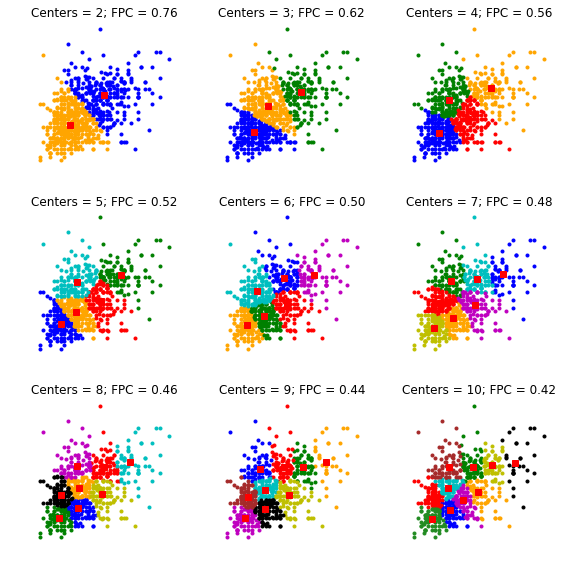

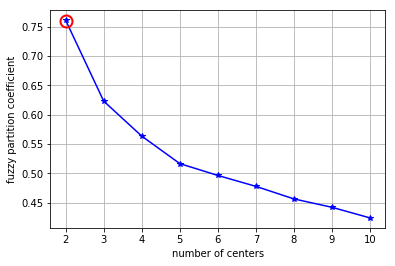

In [77]:
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((df_full['Sp. Atk'].values, df_full['Speed'].values))
fpcs = []

xpts = df_full['Sp. Atk'].values
ypts = df_full['Speed'].values

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=100, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()
plt.show()

fig2, ax2 = plt.subplots()
plt.grid(True)
ax2.plot(np.r_[2:11],fpcs,'b*-')
ax2.plot([2], [0.76], marker='o',
        markersize=12, markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
ax2.set_xlabel('number of centers')
ax2.set_ylabel('fuzzy partition coefficient')
plt.show()

<h3>Evolving Clustering Method</h3>
Work in progress

<h3>Bonus: T distributed Stochastic Neighbour Embedding</h3>
PCA allows us to make use of all of the data, not a limited few dimensions. It is more difficult to interpret however and beyond the scope of this kernel. I'm putting it here just so people know it exists.

In [ ]:
model = TSNE(n_components=2, random_state=0, perplexity=50)
X = df_full[features]
tsne = model.fit_transform(X)

std = StandardScaler()
s = std.fit_transform(X)
pca = PCA(n_components=11)
pca.fit(s)
pc = pca.transform(s)
kmeans = KMeans(n_clusters=5)
kmeans.fit(pc)

fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)